In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('input/train.csv', index_col='Id')
test_data = pd.read_csv('input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice              
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer(strategy="constant")),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

In [4]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 18183.91138356164


In [6]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    # Replace this body with your own code
    pipeline = Pipeline(
    steps=[
        ('preprocessing',SimpleImputer()),
        ('model',RandomForestRegressor(n_estimators=n_estimators,random_state=0))
    ])
    scores = -1 * cross_val_score(pipeline,X,y,cv=3,scoring='neg_mean_absolute_error')
    return scores.mean()

In [7]:
results = dict()

for i in range(50,401,50):
    results[i] = get_score(i)

results

{50: 18353.8393511688,
 100: 18395.2151680032,
 150: 18288.730020956387,
 200: 18248.345889801505,
 250: 18255.26922247291,
 300: 18275.241922621914,
 350: 18270.29183308043,
 400: 18270.197974402367}

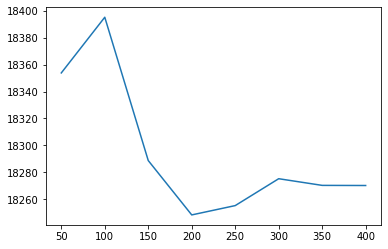

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    'model__max_depth':[5,6,8,10,12],
    'model__n_estimators':[150,200,250,300],
    'model__criterion':['mse','mae']
}

clf = GridSearchCV(my_pipeline,hyperparameters,cv=5,n_jobs=10)
clf.fit(X,y)

# my_pipeline.get_params()

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        SimpleImputer(strategy='constant')),
                                       ('model',
                                        RandomForestRegressor(n_estimators=50,
                                                              random_state=0))]),
             n_jobs=10,
             param_grid={'model__criterion': ['mse', 'mae'],
                         'model__max_depth': [5, 6, 8, 10, 12],
                         'model__n_estimators': [150, 200, 250, 300]})

In [10]:
clf.best_params_

{'model__criterion': 'mae', 'model__max_depth': 12, 'model__n_estimators': 200}

In [11]:
model = clf.best_estimator_

In [12]:
model.fit(X,y)

Pipeline(steps=[('preprocessor', SimpleImputer(strategy='constant')),
                ('model',
                 RandomForestRegressor(criterion='mae', max_depth=12,
                                       n_estimators=200, random_state=0))])

In [13]:
predictions = model.predict(X_test)

In [17]:
predictions.shape

(1459,)

In [20]:
submission = pd.DataFrame(index=X_test.index,columns=['SalePrice'],data=predictions)

In [22]:
submission.to_csv('submission_1.csv')